In [1]:
# import libraries
import os
import yaml
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

tqdm.pandas()
cwd = os.getcwd()
warnings.filterwarnings('ignore')

In [2]:
# load data
data_location = '../local'
train_file_name = 'train.csv'
test_file_name = 'test.csv'

In [3]:
df_train = pd.read_csv(os.path.join(data_location, train_file_name))
df_test = pd.read_csv(os.path.join(data_location, test_file_name))

In [4]:
df_train.head()

,Sentiment,Description
0,neutral,- The Group -� s sales during the period were ...
1,neutral,The medium-term operative targets of the compa...
2,positive,"In addition , Lehdentekijat Oy will start prod..."
3,neutral,Aspo 's Group structure and business operation...
4,neutral,Finnish component supplier Componenta Corporat...


### Visualization

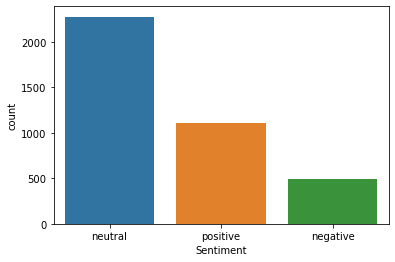

In [5]:
sns.countplot(df_train['Sentiment'])
plt.show()

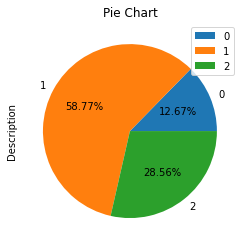

In [6]:
df_train.groupby(['Sentiment']).count()\
.reset_index(drop=True)\
.plot.pie(y='Description', autopct='%.2f%%', title='Pie Chart')
plt.show()

### Preprocessing

In [7]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
with open('../local/configuration.yaml') as f:
    lib_dir = yaml.load(f, yaml.BaseLoader).get('library_directory')
os.chdir(lib_dir)
import func_nlp as func
os.chdir(cwd)

In [8]:
tf.random.set_seed(0)
maxlen = 50

In [9]:
df_train['Description'] = df_train['Description'].progress_apply(lambda x: func.clean_text(x, correct_word=False, special_character=True))
df_test['Description'] = df_test['Description'].progress_apply(lambda x: func.clean_text(x, correct_word=False, special_character=True))

  0%|          | 0/3876 [00:00<?, ?it/s]

  0%|          | 0/970 [00:00<?, ?it/s]

In [10]:
label = LabelEncoder()
df_train['Sentiment'] = label.fit_transform(df_train['Sentiment'])
df_test['Sentiment'] = label.fit_transform(df_test['Sentiment'])

In [11]:
tokenizer = Tokenizer(num_words = 10000, oov_token="<OOV>")
tokenizer.fit_on_texts(df_train['Description'])
word_index = tokenizer.word_index
x_train = tokenizer.texts_to_sequences(df_train['Description'])
x_test = tokenizer.texts_to_sequences(df_test['Description'])
print('Number of unique word: {}'.format(len(word_index)-1))

Number of unique word: 9871


In [12]:
x_train = pad_sequences(x_train, maxlen=maxlen, padding='post', truncating='post')
x_test = pad_sequences(x_test, maxlen=maxlen, padding='post', truncating='post')

In [13]:
y_train = pd.get_dummies(df_train['Sentiment'])

### Model development

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Embedding, Bidirectional, GRU, Flatten, Dense, BatchNormalization, Dropout

In [15]:
tf.random.set_seed(0)

In [16]:
# model detail
model = Sequential(name = 'nlp_financial_news_analysis')
model.add(Input(shape = (maxlen, ), name = 'input_layer'))
model.add(Embedding(input_dim = len(word_index) + 1,
                    output_dim = 16,
                    input_length = maxlen,
                    mask_zero = True))
model.add(Bidirectional(GRU(128)))
model.add(Flatten())
model.add(Dropout(.2))
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(3, name='output_layer', activation='softmax'))

In [17]:
# model configuration
epochs = 15
batch_size = 48
verbose = 1
patience = 2
lr_rate = 1e-3
decay_steps = 100
decay_rate = .5

In [18]:
# call back
monitor_val = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                               patience=patience)
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(lr_rate,
                                               decay_steps=decay_steps,
                                               decay_rate=decay_rate,
                                               staircase=False)

In [19]:
# get best model from the training
checkpoint_filepath = os.path.join(os.getcwd(), 'checkpoints/checkpoint')
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

In [20]:
model.compile(loss = 'categorical_crossentropy',
              optimizer = tf.keras.optimizers.Adam(lr_schedule),
              metrics = ['acc'])

In [21]:
history = model.fit(x_train, 
                    y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=verbose,
                    validation_split=.2,
                    callbacks = [monitor_val, model_checkpoint_callback])

Epoch 1/15
65/65 [==============================] - 5s 84ms/step - loss: 0.9704 - acc: 0.5368 - val_loss: 0.9512 - val_acc: 0.5966
Epoch 2/15
65/65 [==============================] - 3s 44ms/step - loss: 0.6364 - acc: 0.7455 - val_loss: 0.8973 - val_acc: 0.6108
Epoch 3/15
65/65 [==============================] - 3s 43ms/step - loss: 0.3560 - acc: 0.8697 - val_loss: 0.8340 - val_acc: 0.6418
Epoch 4/15
65/65 [==============================] - 3s 44ms/step - loss: 0.2030 - acc: 0.9381 - val_loss: 0.7753 - val_acc: 0.6765
Epoch 5/15
65/65 [==============================] - 3s 43ms/step - loss: 0.1287 - acc: 0.9635 - val_loss: 0.7281 - val_acc: 0.6907
Epoch 6/15
65/65 [==============================] - 3s 43ms/step - loss: 0.0992 - acc: 0.9726 - val_loss: 0.6921 - val_acc: 0.7088
Epoch 7/15
65/65 [==============================] - 3s 43ms/step - loss: 0.0810 - acc: 0.9816 - val_loss: 0.6822 - val_acc: 0.7229
Epoch 8/15
65/65 [==============================] - 3s 42ms/step - loss: 0.0721 - a

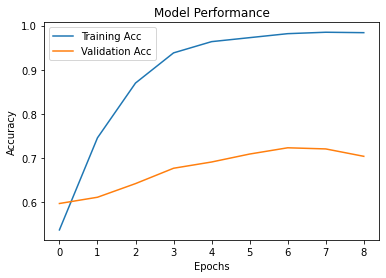

In [22]:
hist = pd.DataFrame(history.history)
hist['epochs'] = history.epoch
plt.figure()
plt.plot(hist['epochs'], hist['acc'], label='Training Acc')
plt.plot(hist['epochs'], hist['val_acc'], label='Validation Acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Performance')
plt.legend()
plt.show()

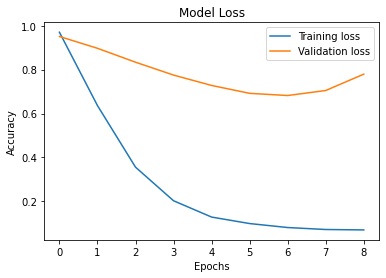

In [23]:
plt.figure()
plt.plot(hist['epochs'], hist['loss'], label='Training loss')
plt.plot(hist['epochs'], hist['val_loss'], label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Loss')
plt.legend()
plt.show()

In [24]:
# store trained model
filename = 'firstSubmission.h5'
model.save(filename)

In [25]:
# load library
from sklearn.metrics import confusion_matrix, classification_report

In [26]:
model.load_weights(checkpoint_filepath)
df_test['y_pred'] = np.argmax(model.predict(x_test), axis=1)

In [27]:
confusion_matrix(df_test['Sentiment'], df_test['y_pred'])

array([[ 32,  52,  29],
       [  4, 553,  44],
       [ 10, 119, 127]], dtype=int64)

In [28]:
print(classification_report(df_test['Sentiment'], df_test['y_pred']))

              precision    recall  f1-score   support

           0       0.70      0.28      0.40       113
           1       0.76      0.92      0.83       601
           2       0.64      0.50      0.56       256

    accuracy                           0.73       970
   macro avg       0.70      0.57      0.60       970
weighted avg       0.72      0.73      0.71       970



In [29]:
df_test.to_csv('../submission/firstSubmission.csv', index=False, header=True)